# Введение в анализ данных, ИАД-2  
  
# НИУ ВШЭ, 2019-20 учебный год
## Домашнее задание №2  

Задание выполнил: Ковалев Владислав Сергеевич

In [131]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, f_regression
from sklearn.linear_model import LinearRegression as LR, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures, OneHotEncoder as OHE
import re
from collections import Counter

%matplotlib inline


# kNN своими руками
Реализуйте взвешенный алгоритм kNN для регрессии. Пусть нам нужно вычислить значение $y$ для некоторого $x$ при известных данных $\left(x_1, y_1\right), \ldots, \left(x_\ell, y_\ell\right)$. Предсказанием вашего регрессора будет являться

$ \hat{y} = \frac{\sum\limits_{i=1}^kw_iy_{(i)}}{\sum\limits_{i=1}^kw_i}, $  
где   $\left(x_{(1)}, y_{(1)}\right), \ldots, \left(x_{(k)}, y_{(k)}\right)$   - ближайшие $k$ объектов к $x$ по некоторой метрике   $ d(\cdot, \cdot)$, а $w_i = \frac{1}{d\left(x, x_{(i)}\right)}$  . Ваш алгоритм должен уметь работать с двумя метриками:

$ d\left(x_{(i)}, x\right) = \|x_{(i)} - x\|_2 = \sqrt{\sum\limits_{j=1}^n\left(x_{(i)}^j - x^j\right)^2}\qquad\text{(евклидова)}$  
$ d\left(x_{(i)}, x\right) = \|x_{(i)} - x\|_1 = \sum\limits_{j=1}^n\left|x_{(i)}^j - x^j\right|\qquad\text{(манхэттена)} $    
Сверьте для нескольких комбинаций различных параметров свой результат на искусственной выборке с результатом соответствующего алгоритма из sklearn по метрике качества MSE

In [206]:
def euclid(X, vopr, k):
    rast = []
    for i in range(len(X)):
        dist = 0
        for j in range(len(X[i])):
            dist += (X[i][j] - vopr[j])**2
        if dist == 0:
            global index 
            index = i
            raise ZeroDivisionError
        rast.append((i, 1/(dist ** 0.5)))
    rast.sort(key = lambda x: x[1], reverse=True)
    return rast[:k]

In [207]:
def euclid_metric(X, Y):
    return np.sqrt(np.sum((X-Y)**2))

In [208]:
def manhattan(X, vopr, k):
    rast = []
    for i in range(len(X)):
        dist = 0
        for j in range(len(X[i])):
            dist = abs(X[i][j] - vopr[j])
        if dist == 0:
            global index 
            index = i
            raise ZeroDivisionError
        rast.append((i, 1/(dist ** 0.5)))
    rast.sort(key = lambda x: x[1], reverse=True)
    return rast[:k]

In [209]:
class KNN:
    def __init__(self, metric='euclid', k=5):
        """
        PARAMETERS:
        metric ('euclid' or 'manhattan')
        k - number of nearest neighbors
        """
        
        self.metric = metric
        self.k = k
        
        self.X_train = None
        self.y_train = None
        
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        return self
        
    def predict(self, X_test): 
        w = []
        y_pred = np.zeros(len(X_test))
        if self.metric == 'euclid':
            for i in range(len(X_test)):
                try:
                    w.append(euclid(self.X_train, X_test[i], self.k))
                except ZeroDivisionError:
                    y_pred[i] = self.y_train[index]
            for item in range(len(w)):
                if y_pred[item] == 0:
                    wres = 0
                    y_result = 0
                    for j in w[item]:
                        y_result += j[1]*self.y_train[j[0]]
                        wres += j[1]
                    y_pred[item] = y_result/wres
                else:
                    pass
        elif self.metric == 'manhattan':
            for i in range(len(X_test)):
                try:
                    w.append(manhattan(self.X_train, X_test[i], self.k))
                except ZeroDivisionError:
                    y_pred[i] = self.y_train[index]
            for item in range(len(w)):
                if y_pred[item] == 0:
                    wres = 0
                    y_result = 0
                    for j in w[item]:
                        y_result += j[1]*self.y_train[j[0]]
                        wres += j[1]
                    y_pred[item] = y_result/wres
                else:
                    pass
        
        
        return y_pred

## Проверка скрипта KNN своими руками с библиотекой SCLEARN

In [210]:
np.random.seed(17032019)
X_train = np.random.randn(1000, 50)
y_train = np.random.randn(1000,)
X_test = np.random.randn(500, 50)
y_test = np.random.randn(500,)

In [211]:
qwer = KNN(k = 5)
qwer.fit(X_train, y_train)
y1_pred = qwer.predict(X_test)

In [212]:
neigh = KNeighborsRegressor(n_neighbors=5, weights = 'distance')
neigh.fit(X_train, y_train)
y2_pred = neigh.predict(X_test)

In [213]:
print('MSE KNN руками: ', mean_squared_error(y_test ,y1_pred))
print('MSE KNN sclearn: ', mean_squared_error(y_test ,y2_pred))

MSE KNN руками:  1.143364989935662
MSE KNN sclearn:  1.143364989935662


# Линейная регрессия своими руками 
Реализуйте линейную регрессию с градиентным спуском для функции потерь Хьюбера:

$$
L_\delta\left(y, \hat{y}\right) =
\begin{cases}
\frac{1}{2}\left(y - \hat{y}\right)^2, \qquad &amp;|y - \hat{y}| \leq \delta\\
\delta\left|y - \hat{y}\right| - \frac{1}{2}\delta^2,\qquad &amp; \text{otherwise}
\end{cases}
$$
В таком случае общее значение функции потерь на всем датасете $(x_1, y_1), \ldots, (x_\ell, y_\ell)$ будет равно $ L = \frac{1}{\ell}\sum\limits_{i=1}^\ell L_\delta\left(y_i, \hat{y}_i\right) $  
Проверьте работу вашего метода: выведите результаты его работы на той же искусственной выборке, что и в задаче выше (в качестве метрик качества используйте MSE и Huber loss). Постройте график зависимости значения функции потерь от итерации градиентного спуска.

Вы можете опустить единичный признак в модели и не добавлять его в данные. Для данной искусственной выборки это не актуально, потому что целевая переменная в этом случае является случайной величиной из стандартного нормального распределения со средним 0.

Вектор весов в градиентном спуске можете инициализировать нулями.

In [342]:
class LinearRegressionHuber:
    def __init__(self, delta=1.0, max_iter=1000, tol=1e-6, eta=1e-2):
        
        self.delta = delta
        self.max_iter = max_iter
        self.tol = tol
        self.eta = eta
        
        self.w = None
        self.loss_history = None
        self.grad = None
        
    def fit(self, X_train, y_train):
        
        self.grad = np.zeros_like(X_train)
        self.w = np.zeros(len(X_train[0]))
        y_krish = X_train.dot(self.w)
        L = np.sum(np.where(abs(y_train - y_krish) <= self.delta, ((y_train - y_krish) ** 2) / 2, 
                                self.delta * abs((y_train - y_krish)) - 
                                (self.delta ** 2) / 2)) / len(X_train)
        self.loss_history = [L]
        old_w = self.w.copy()
        vsp_matr = np.zeros_like(X_train)
        for i in range(len(X_train)):  
            if abs(y_train[i] - y_krish[i]) <= self.delta:
                 vsp_matr[i] = (-1)*X_train[i]*(y_train[i] - y_krish[i])
            else:
                if y_train[i] - y_krish[i] < 0:
                    vsp_matr[i] = self.delta*X_train[i]
                else:
                    vsp_matr[i] = -self.delta*X_train[i]
        self.w = (-1)*self.eta * (np.sum(vsp_matr, axis=0) / len(X_train))
        y_krish = X_train.dot(self.w)
        self.grad [0] = np.sum(vsp_matr, axis=0) / len(X_train)
        L = np.sum(np.where(abs(y_train - y_krish) <= self.delta, ((y_train - y_krish) ** 2) / 2, 
                                self.delta * abs((y_train - y_krish)) - 
                                (self.delta ** 2) / 2)) / len(X_train)
        
        self.loss_history.append(L) 
        
        schet = 0
        while euclid_metric(self.w, old_w) > self.tol and schet != self.max_iter-2: 
            schet += 1
            old_w = self.w.copy()
            vsp_matr = np.zeros_like(X_train)
            for i in range(len(X_train)):
                if abs(y_train[i] - y_krish[i]) <= self.delta:
                    vsp_matr[i] = (-1)*X_train[i]*(y_train[i] - y_krish[i])  
                else:
                    if y_train[i] - y_krish[i] < 0:
                        vsp_matr[i] = self.delta*X_train[i]
                    else:
                        vsp_matr[i] = -self.delta*X_train[i]
            self.w = old_w - self.eta * (np.sum(vsp_matr, axis=0) / len(X_train))
            self.grad[schet] = np.sum(vsp_matr, axis=0) / len(X_train) 
            y_krish = X_train.dot(self.w)
            L = np.sum(np.where(abs(y_train - y_krish) < self.delta, ((y_train - y_krish) ** 2) / 2, 
                                self.delta * abs((y_train - y_krish)) - 
                                (self.delta ** 2) / 2)) / len(X_train)
            self.loss_history.append(L) 
            
        return self.loss_history
        
    def predict(self, X_test):
        
        y_pred = X_test.dot(self.w)
        
        return y_pred
    
    def calc_gradient(self, X, y):
        
        grad = self.grad[self.max_iter//2]
        
        return grad
    
    def calc_loss(self, X, y):
        
        loss = np.array(self.loss_history).mean()
        
        return loss

In [215]:
k = LinearRegressionHuber()
Loss = k.fit(X_train, y_train)

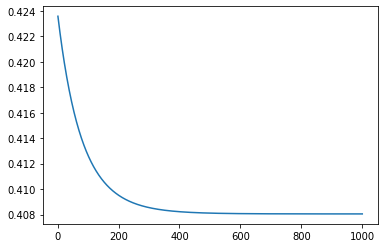

In [216]:
plt.plot(np.linspace(1, 1000, 1000), Loss)
plt.xlim()
plt.ylim()
plt.show()


In [217]:
pred = LR().fit(X_train, y_train)
y3_pred = k.predict(X_test)
y4_pred = pred.predict(X_test)

In [218]:
print('MSE LR руками: ', mean_squared_error(y_test ,y3_pred))
print('MSE LR sclearn: ', mean_squared_error(y_test ,y4_pred))

MSE LR руками:  1.0919500874768941
MSE LR sclearn:  1.08825396188117


In [219]:
print('Calc_loss: ', k.calc_loss(X_train, y_train))

Calc_loss:  0.409353385047645


In [220]:
print('Grad:', k.calc_gradient(X_train, y_train))

Grad: [-1.04372600e-03 -7.68346999e-04  1.20685826e-04  2.53619880e-04
 -1.28547571e-03 -1.00743912e-03  1.51932981e-05 -2.07574304e-04
 -1.85004980e-03  7.43381059e-04  2.65183035e-04  3.47228053e-03
  9.88670024e-04  1.93563038e-04  1.67045684e-03 -8.23286604e-04
 -2.04204365e-03  1.10503290e-03 -1.84128161e-04  1.93667425e-04
 -2.39991769e-03  4.02876738e-04  1.05532003e-03 -1.24019299e-03
  1.30454360e-03 -2.23752066e-05 -5.55721235e-04  7.47098830e-04
  2.92661126e-04  1.92494738e-04  2.94676789e-04  1.42945726e-04
 -2.84767372e-04  6.03252248e-04  1.82991231e-03  1.13040990e-03
  5.37049695e-04 -1.20690399e-03 -2.76294525e-04 -6.29036492e-04
 -1.86094443e-03  3.52424067e-04 -1.31345253e-03  1.00918709e-03
  2.55335330e-04 -5.97143597e-04 -2.26223099e-04 -2.07235370e-03
  4.46843190e-04  1.40222945e-03]


# Практика


In [257]:
data = pd.read_csv('train_hw2.csv', header=0)

In [258]:
data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [259]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [260]:
data.drop('Id', axis=1, inplace=True)


## Задание 1

Есть ли в данных пропуски? Если да, то для каждого столбца, в котором они имеются, посчитайте их количество и их долю от общего числа значений. Что вы наблюдаете?

In [261]:
list_of_names = list(data.columns)
list_of_names_with_miss = []
counter = 0
for i in list_of_names:
    counter = data[i].isnull().sum()
    if counter == 0:
        pass
    else:
        list_of_names_with_miss.append(i)
        print('Доля пропусков в {:s} от общего числа значений: {:f}%'.format(i, (counter/len(data))*100))

Доля пропусков в LotFrontage от общего числа значений: 17.739726%
Доля пропусков в Alley от общего числа значений: 93.767123%
Доля пропусков в MasVnrType от общего числа значений: 0.547945%
Доля пропусков в MasVnrArea от общего числа значений: 0.547945%
Доля пропусков в BsmtQual от общего числа значений: 2.534247%
Доля пропусков в BsmtCond от общего числа значений: 2.534247%
Доля пропусков в BsmtExposure от общего числа значений: 2.602740%
Доля пропусков в BsmtFinType1 от общего числа значений: 2.534247%
Доля пропусков в BsmtFinType2 от общего числа значений: 2.602740%
Доля пропусков в Electrical от общего числа значений: 0.068493%
Доля пропусков в FireplaceQu от общего числа значений: 47.260274%
Доля пропусков в GarageType от общего числа значений: 5.547945%
Доля пропусков в GarageYrBlt от общего числа значений: 5.547945%
Доля пропусков в GarageFinish от общего числа значений: 5.547945%
Доля пропусков в GarageQual от общего числа значений: 5.547945%
Доля пропусков в GarageCond от обще

Наблюдаю, что больше всего пропусков в признаках Alley, PoolQC, Fence, MiscFeature, FireplaceQu

## Задание 2
Избавьтесь от пропусков. Для каждого из примененных методов обоснуйте свое решение. Проверьте, что вы действительно избавились от пропусков.

Напоминание. В зависимости от типа столбца, можно заполнить пропуски, например, средним арифметическим, медианой, модой, можно какими-то отдельными значениями. А можно такие столбцы вообще удалить.

In [262]:
data.drop('Alley', axis=1, inplace=True)
data.drop('FireplaceQu', axis=1, inplace=True)
data.drop('PoolQC', axis=1, inplace=True)
data.drop('MiscFeature', axis=1, inplace=True)
data.drop('Fence', axis=1, inplace=True)

In [263]:
values_of_column = {}
for i in list_of_names_with_miss:
    vsp_list = []
    try:
        for j in data[i]:
            vsp_list.append(j)
        if len(set(vsp_list)) < 10:
            values_of_column.update({i : set(vsp_list)})
            print(i, set(vsp_list))
    except KeyError:
        pass


MasVnrType {nan, 'BrkCmn', 'None', 'Stone', 'BrkFace'}
BsmtQual {nan, 'Gd', 'Ex', 'Fa', 'TA'}
BsmtCond {nan, 'Gd', 'Po', 'TA', 'Fa'}
BsmtExposure {nan, 'Gd', 'Av', 'No', 'Mn'}
BsmtFinType1 {nan, 'LwQ', 'Unf', 'ALQ', 'BLQ', 'Rec', 'GLQ'}
BsmtFinType2 {nan, 'LwQ', 'Unf', 'ALQ', 'BLQ', 'Rec', 'GLQ'}
Electrical {nan, 'FuseA', 'FuseF', 'FuseP', 'SBrkr', 'Mix'}
GarageType {nan, 'BuiltIn', 'CarPort', 'Attchd', 'Basment', 'Detchd', '2Types'}
GarageFinish {'Unf', nan, 'Fin', 'RFn'}
GarageQual {nan, 'Gd', 'Po', 'Ex', 'TA', 'Fa'}
GarageCond {nan, 'Gd', 'Po', 'TA', 'Fa', 'Ex'}


In [264]:
top_words = []
for i in values_of_column:
    vsp_str = ''
    for j in data[i]:
        try:
            vsp_str += ' ' + str(j) + ' '
        except TypeError: 
            vsp_str += str(' nan ')
    priz = re.findall(r'\w+', vsp_str)
    word_counts = Counter(priz)
    top_words.append((i, word_counts.most_common(1)[0][0]))
for i in top_words:
    data[i[0]].fillna(i[1], inplace=True)

Воспользовался методом заполнения пропусков в категориальных признаках популярным значением так как заполнение не критически влияет на корреляцию и среднее значение

In [265]:
miss_1 = data['LotFrontage'].dropna()
miss_2 = data['MasVnrArea'].dropna()
miss_3 = data['GarageYrBlt'].dropna()
data['LotFrontage'].fillna(miss_1.mean(), inplace=True)
data['MasVnrArea'].fillna(miss_2.mean(), inplace=True)
data['GarageYrBlt'].fillna(miss_3.mean(), inplace=True)
print('Проверка - >')
if not data.isnull().any().any():
    print('В данных пропусков нет!')
else:
    print('В данных есть пропуски!')

Проверка - >
В данных пропусков нет!


## Задание 3

Обработайте категориальные признаки. В их обнаружении вам может помочь синтаксис pandas (например, можно обратить внимание на типы столбцов), а также описание датасета и его исследование. Объясните выбор метода (one-hot-encoding, label encoding, ...)

In [266]:
list_names = data.columns
list_values = list(data[1:2].values)
list_of_cat_names = []
j = 0
for i in list_names:
    if type(data[1:2][i].values[0]) == str:
        list_of_cat_names.append(i)
        j += 1

In [268]:
new_data = None
for i in list_of_cat_names:
    data_cat = data[i]
    new_data = pd.concat([new_data, pd.get_dummies(data_cat,prefix=i)], axis=1, sort = False)

In [269]:
new_data = pd.concat([data, new_data], axis=1, sort=False)

In [270]:
for i in list_of_cat_names:
    new_data.drop(i, axis=1, inplace=True)

In [271]:
new_data

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,0,0,0,1,0,0,0,0,1,0
1456,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,0,0,0,1,0,0,0,0,1,0
1457,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,0,0,0,1,0,0,0,0,1,0
1458,20,68.0,9717,5,6,1950,1996,0.0,49,1029,...,0,0,0,1,0,0,0,0,1,0


Воспользовался One-Hot Encoding для лучшей корреляции признаков

## Задание 4  
Вычислите и визуализируйте попарную корреляцию Пирсона между всеми признаками. Какие выводы можно сделать?

Для визуализации можно использовать seaborn.heatmap().

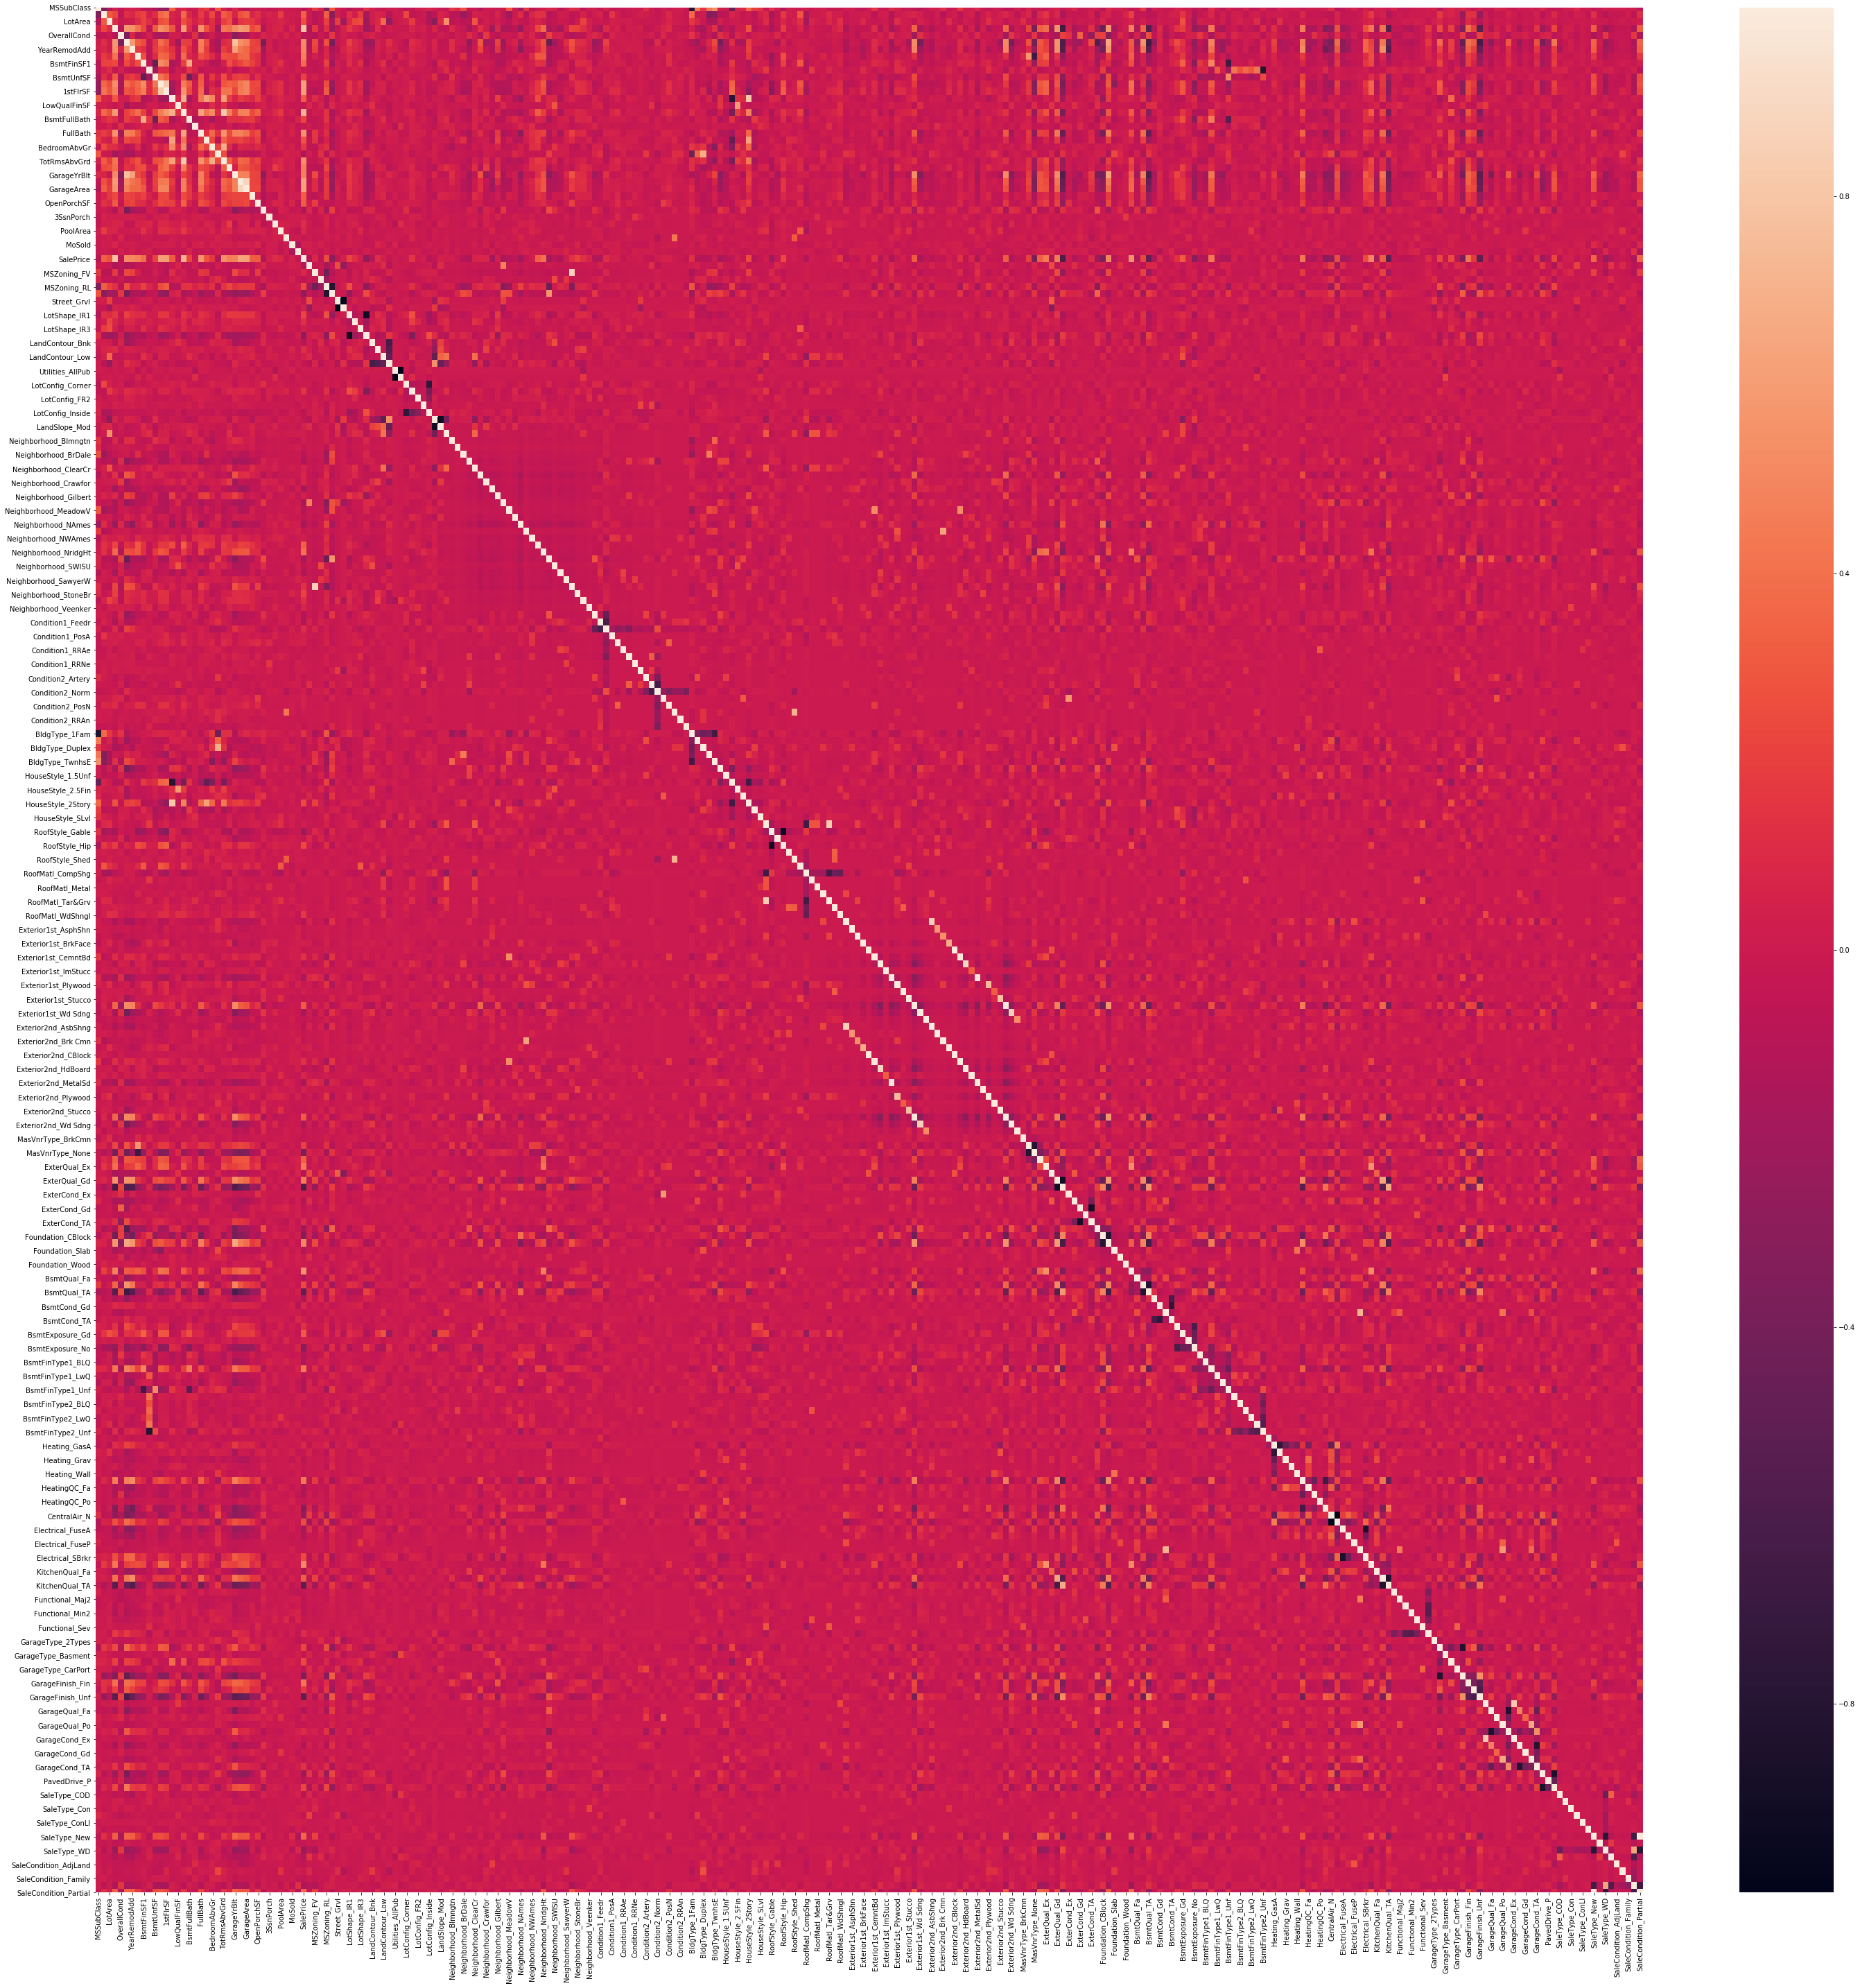

In [317]:
plt.figure(figsize=(50, 50))
sns.heatmap(new_data.corr())

Много признаков не имеют корреляции среди других

## Задание 5  

Найдите признаки с максимальным и минимальным абсолютным значением коэффициента корреляции Пирсона с предсказываемым значением. Изобразите на графиках зависимость найденных признаков от предсказываемого значения.

Не забудьте указать название графика и обозначить, что изображено по каждой из осей.

In [298]:
max_corr = -1
min_corr = 1
index = 0
for i in new_data.corr()['SalePrice']:
    a_i = abs(i)
    if a_i > max_corr and a_i != 1:
        max_corr = a_i
        i_max = index
    if a_i < min_corr:
        min_corr = a_i
        i_min = index
    index += 1
print(new_data.corr().columns[i_max], max_corr)
print(new_data.corr().columns[i_min], min_corr)

OverallQual 0.7909816005838047
BsmtFinType2_GLQ 7.551406179757809e-05


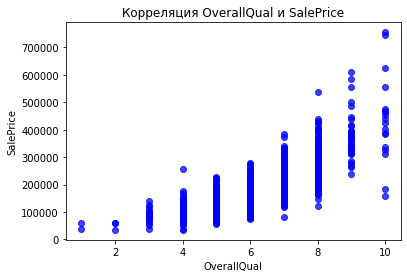

In [307]:
plt.subplots()
plt.scatter(new_data['OverallQual'], new_data['SalePrice'], color = 'b', alpha = 0.75)
plt.title('Корреляция OverallQual и SalePrice')
plt.ylabel('SalePrice')
plt.xlabel('OverallQual')
plt.show()

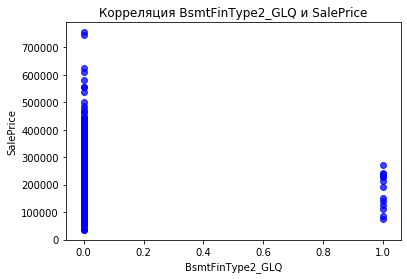

In [306]:
plt.subplots()
plt.scatter(new_data['BsmtFinType2_GLQ'], new_data['SalePrice'], color = 'b', alpha = 0.75)
plt.title('Корреляция BsmtFinType2_GLQ и SalePrice')
plt.ylabel('SalePrice')
plt.xlabel('BsmtFinType2_GLQ')
plt.show()

## Задание 6  
Постройте гистограмму распределения предсказываемого значения. Для избавления от разницы в масштабах, а также «смещения» распределения переменной в сторону нормального (что бывает полезно при статистическом анализе), можно прологарифмировать ее (это обратимое преобразование, поэтому целевую переменную легко восстановить). В данном случае воспользуйтесь numpy.log1p, чтобы сделать преобразование $y \to \ln\left(1 + y\right)$. Постройте гистограмму распределения от нового предсказываемого значения. Опишите наблюдения.

В дальнейшем используйте в качестве предсказываемого значения вектор, который получился после логарифмирования.

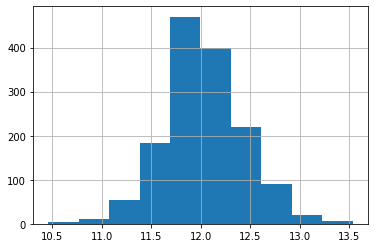

In [309]:
np.log1p(data['SalePrice']).hist()

In [616]:
X_train, X_val, y_train, y_val = train_test_split(new_data.drop('SalePrice', axis=1), np.log1p(new_data['SalePrice']), random_state=17032019, train_size = 0.901111111)

In [617]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1315, 270), (145, 270), (1315,), (145,))

## Задание 7
Примените к данным следующие алгоритмы:

* kNN  
* линейная регрессия  
* Lasso  
* Ridge   
 
Для каждого из методов подберите гиперпараметры с помощью кросс-валидации. Обучите алгоритмы с лучшими гиперпараметрами на обучающей выборке и оцените качество по метрике Root Mean Squared Error. Какой из методов показывает себя лучше?

In [618]:
K1 = KNeighborsRegressor(n_neighbors=11, weights = 'distance')
K1.fit(X_train, y_train)
y_KNN = K1.predict(X_val)
mean_squared_error(y_val ,y_KNN)**0.5

0.20844016434347465

In [626]:
K2 = LR().fit(X_train, y_train)
y_LR = K2.predict(X_val)
mean_squared_error(y_val ,y_LR)**0.5

0.12584201947623658

In [639]:
K3 = Lasso().fit(X_train, y_train)
y_Lasso = K3.predict(X_val)
mean_squared_error(y_val ,y_Lasso)**0.5

0.1695945163711614

In [621]:
K4 = Ridge(alpha = 34, fit_intercept = True).fit(X_train, y_train)
y_Ridge = K4.predict(X_val)
mean_squared_error(y_val ,y_Ridge)**0.5

0.12090439705809247

In [607]:
lis1 = []
for j in np.linspace(0.9, 0.91, 10):
    X_train, X_val, y_train, y_val = train_test_split(new_data.drop('SalePrice', axis=1), np.log1p(new_data['SalePrice']), train_size = j, random_state=17032019)
    for i in range(50):
        K4 = Ridge(alpha=i).fit(X_train, y_train)
        y_Ridge = K4.predict(X_val)
        lis1.append([i, j, mean_squared_error(y_val ,y_Ridge)**0.5])

In [608]:
lis1.sort(key=lambda x: x[2])

In [609]:
lis1

[[34, 0.9011111111111111, 0.12090439705809247],
 [35, 0.9011111111111111, 0.12090459446105559],
 [33, 0.9011111111111111, 0.12090509016930491],
 [36, 0.9011111111111111, 0.12090562226817846],
 [32, 0.9011111111111111, 0.12090674005673607],
 [37, 0.9011111111111111, 0.12090742579399569],
 [31, 0.9011111111111111, 0.12090941998365953],
 [38, 0.9011111111111111, 0.12090995515204189],
 [39, 0.9011111111111111, 0.12091316471503749],
 [30, 0.9011111111111111, 0.12091321120969112],
 [40, 0.9011111111111111, 0.12091701264744877],
 [29, 0.9011111111111111, 0.120918204161646],
 [41, 0.9011111111111111, 0.12092146049937134],
 [28, 0.9011111111111111, 0.12092449981699349],
 [42, 0.9011111111111111, 0.12092647285256843],
 [43, 0.9011111111111111, 0.12093201701100578],
 [27, 0.9011111111111111, 0.12093221134580107],
 [44, 0.9011111111111111, 0.12093806272948737],
 [26, 0.9011111111111111, 0.12094146606852432],
 [45, 0.9011111111111111, 0.12094458197501037],
 [46, 0.9011111111111111, 0.12095154871630

Обучил Ridge (Лучший метод) подобрав гиперпараметры для кросс-валидации и Ridge alpha в цикле, так как ограничений на гиперпараметр кросс-валидации ничего нет

## Задание 8
Постройте гистограммы значений весов для линейной регрессии, Lasso и Ridge. Опишите наблюдения. В чем различия между полученными наборами весов и почему?

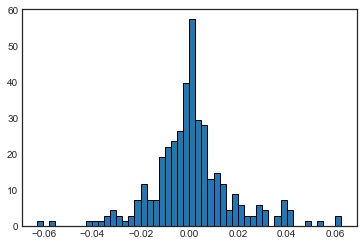

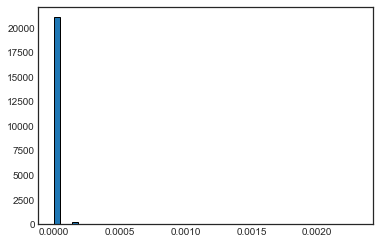

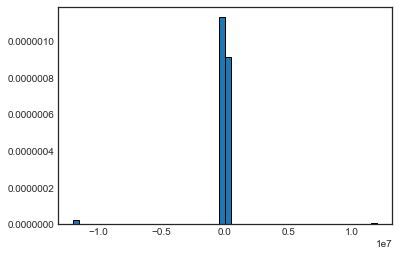

In [640]:
w4 = K4.coef_
w3 = K3.coef_
w2 = K2.coef_
plt.hist(w4, bins = 50, density = True, ec='k')
plt.show()
plt.hist(w3, bins = 50, density = True, ec='k')
plt.show()
plt.hist(w2, bins = 50, density = True, ec='k')
plt.show()

Видно, что Ridge подбирает куда больше зависимостей Price от параметров нежели Lasso и LR которые выбирают только несколько существенных весов по которым дальше строют свои предсказания 

## Задание 9, 10

In [643]:
K4 = Ridge(alpha = 34, fit_intercept = True).fit(X_train, y_train)
y_Ridge = K4.predict(X_val)
print('Ridge RMSE:', mean_squared_error(y_val ,y_Ridge)**0.5)

Ridge RMSE: 0.12090439705809247


# Теория
Найдите константу $C$, решающую следующую задачу ($0 < \tau < 1$ фиксировано):

$$
\sum\limits_{i=1}^\ell\rho_\tau\left(y_i - C\right) \to \min_C,
$$

где

$$
\rho_\tau(z) =
\begin{cases}
\tau z, & z > 0\\
(\tau - 1)z, & z \leq 0
\end{cases}
$$

# Решение

Запишем функцию $\rho_\tau (y_i-C)$:

$$
\rho_\tau(y_i-C) =
\begin{cases}
\tau (y_i-C), & y_i - C > 0\\
(\tau - 1)(y_i-C), & y_i - C \leq 0
\end{cases}
$$


Посчитаем производную по $C$ от данной суммы и прировняем ее к нулю, чтобы найти минимальное значение суммы в зависимости от константы

FOC:
$$
\left(\sum_{i=1}^\ell \rho_\tau(y_i - C)\right)'_{C} = 0\\
\sum_{i=1}^\ell \rho'_C (y_i-C)  = 0
$$

Найдем производную $\rho'_C (y_i-C)$:

$$
\rho'_C (y_i-C) =
\begin{cases}
-\tau, & y_i - C > 0\\
(1-\tau), & y_i - C \leq 0
\end{cases}
$$

Упорядочим все $y$.

Тогда пусть $C\in[y_k;y_{k+1}]$, откуда эта сумма производных считается как

$$
\sum_{i=1}^\ell \rho'_C (y_i-C) = k - \ell \tau = 0
$$

Однако может произойти так, что не существует такой k, то есть $\exists k, k\in \mathbb {N}, k \le \ell: k - l\tau > 0 \text{ и } k-1 - l\tau < 0$, или для всех k имеем, что $k - \ell \tau > 0$, или для всех k имеем, что $k - \ell \tau < 0$ (но такого быть не может, так как по условию $1-\tau > 0$, значит для $k = \ell$ будет $\ell - \ell \tau = \ell (1-\tau) > 0$).

Заметим, что в первом случае получаем, что до какого-то момента функция убывала, а потом начала расти, причем это происходит ровно в момент равенства $C=y_k$, то есть в этой точке функция достигает свое минимальное значение.

Для второго случая имеем, что функция монотонно растет, тогда нужно брать крайнюю точку ($C=y_{min}$, причем минимум будет достигаться именно в ней, так как иначе выбирая значения меньше к сумме будет прибавляться еще что-то, а так для крайних слагаемых функция $\rho_\tau (y_i-C)$ принимает нулевые значения).

Проверяя условие на вторую производную имеем, что она будет нулевой, так как мы берем производную от константы (первая производная уже не зависит от константы).

Подводя итог, получаем, что искомая $C^*$ равна:

$$
C^* = \begin{cases}
[y_{k};y_{k+1}], \text{если }\exists k, k \in \mathbb {N}: k - l\tau = 0\\
y_k, \text{если } \exists k, k\in \mathbb {N}: k - l\tau > 0 \text{ и } k-1 - l\tau < 0\\
y_{min}, \text{если } \forall k, k \le \ell, (k-\ell \tau) > 0
\end{cases}
$$